# Baseline Models

Here we walk through some data exploration and do work on our baseline models.

The outline is as follows:

* Look at data and run simple logistic regression classifer on data
* Try resampling methods using this classifer 
* Implement other baseline classifiers using the best resampling technique 
* See briefly what tuning can be done

### Imports and printing utility

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools

from IPython.core.display import HTML

HTML("""
<style>
 {
    display: table-cell;
    text-align: center;
   .output_png vertical-align: middle;
}
</style>
""")

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

This is a function that prints a nice plot of the confusion matrix, that'll be useful to use later on.

### Read in Data

In [43]:
data = pd.read_csv("creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


As we can see, the features have been normalised, except Time and Amount.

### View data balance

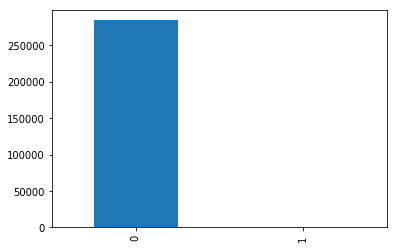

0    284315
1       492
Name: Class, dtype: int64


In [44]:
# Print a plot of class balance
classes = pd.value_counts(data['Class'], sort=True).sort_index()
classes.plot(kind = 'bar')
plt.show()
print classes

### Normalise the Amount column and drop the Time column and the old Amount column

In [45]:
# Normalise and reshape the Amount column, so it's values lie between -1 and 1
from sklearn.preprocessing import StandardScaler
data['norm_Amount'] = StandardScaler().fit_transform(data['Amount'].reshape(-1,1))

# Drop the old Amount column and also the Time column as we don't want to include this at this stage
data = data.drop(['Time', 'Amount'], axis=1)

data.head()

/Users/HarryG1/Documents/University/Year_3/DeepLearning-CreditCardFraud/devEnv/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,norm_Amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


## Logistic regression (without sampling)

Let's setup a logistic regression classifier to run on our data.

### Imports and classifer instantiation 

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report 

# Call the logistic regression model with a certain C parameter
lr = LogisticRegression(C = 10)

### Assign data to x and y and perform a train-test split on the data

In [47]:
# Assign variables x and y corresponding to row data and it's class value
X = data.ix[:, data.columns != 'Class']
y = data.ix[:, data.columns == 'Class']

# Whole dataset, training-test data splitting
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 0)

/Users/HarryG1/Documents/University/Year_3/DeepLearning-CreditCardFraud/devEnv/lib/python2.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


### Here we perform cross validation
The reason we do this is so we compute an average of runs of our classifier, to be confident in it's results. The scoring metric here is defined as Recall as this is the metric we are most interested in. If you wanted the whole confusion matrix metrics performed under cross-val then you would need to essentially run cross-val yourself, looping over iterations and storing the matrix results. For the purposes of this, we'll just look at Recall.

In [48]:
# CROSS VALIDATION
scores = cross_val_score(lr, X, y, scoring='recall', cv=5)
print scores
print 'Recall mean = ', np.mean(scores)

[ 0.74747475  0.63636364  0.42857143  0.68367347  0.51020408]
Recall mean =  0.601257472686


### Fit the data in a single run and print a confusion matrix
This is just a single run for the purposes of printing a confusion matrix to give us a visualisation of how the classifer performed.

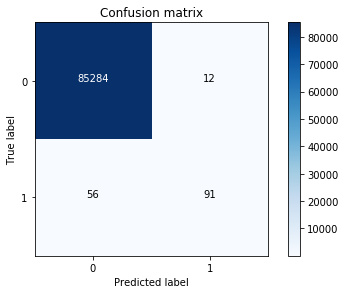

In [49]:
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
class_names = [0,1]


plt.figure()
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')
plt.show()

### Print classification report

In [50]:

from sklearn.metrics import classification_report
print classification_report(y_test, y_pred)

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     85296
          1       0.88      0.62      0.73       147

avg / total       1.00      1.00      1.00     85443



### Evaluation

So, as we can see, without any sampling techniques on the data, running a simple logistic regression gives us a recall score average of around 60%. 

This is pretty bad. That means that nearly 40% of fraudlent cases were incorrectly predicted. 

## Aside on C parameter of Logistic regression

The C parameter of the logistic regression is essentially a regularisation parameter. Increasing the regularisation strength penalises "large" weight coefficients. This is mainly so that the model performs better on unseen data and avoids learning anomolies or noise.

#### To determine the best value to give this parameter we can do a quick hyper-parameter tuning, namely Grid Search, to find the best value to use:

In [54]:
from sklearn.model_selection import GridSearchCV

# Call the logistic regression model with a certain C parameter
lr = GridSearchCV(LogisticRegression(C = 0.01), {'C':[0.01, 0.1, 1, 10, 100]}, scoring='recall')

# Assign variables x and y corresponding to row data and it's class value
X = data.ix[:, data.columns != 'Class']
y = data.ix[:, data.columns == 'Class']

# # Whole dataset, training-test data splitting
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 0)

# # CROSS VALIDATION
# scores = cross_val_score(lr, X, y, scoring='recall', cv=5)
# print scores
# print 'Recall mean = ', np.mean(scores)

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# cm = confusion_matrix(y_test, y_pred)
# class_names = [0,1]

print("Best parameters set found on development set:")
print ""
print(lr.best_params_)
print ""
print("Grid scores on development set:")
print ""
means = lr.cv_results_['mean_test_score']
stds = lr.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, lr.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print ""

print("Detailed classification report:")
print ""
print classification_report(y_test, y_pred)
print ""
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print ""


Best parameters set found on development set:

{'C': 10}

Grid scores on development set:

0.583 (+/-0.150) for {'C': 0.01}
0.606 (+/-0.110) for {'C': 0.1}
0.620 (+/-0.107) for {'C': 1}
0.623 (+/-0.122) for {'C': 10}
0.623 (+/-0.122) for {'C': 100}

Detailed classification report:

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     85296
          1       0.88      0.62      0.73       147

avg / total       1.00      1.00      1.00     85443


The model is trained on the full development set.
The scores are computed on the full evaluation set.



#### So we can see here that C=10 is the best value to use.

## Undersampling 

#### Here, we will attempt undersampling by reducing the number of the majority class, down to a 50:50 ratio with the minority class

Number of frauds 492
number of non fraud:  284315
non_fraud after:  492
[ 0.83838384  0.8989899   0.85714286  0.92857143  0.8877551 ]
Recall mean =  0.882168625026


/Users/HarryG1/Documents/University/Year_3/DeepLearning-CreditCardFraud/devEnv/lib/python2.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


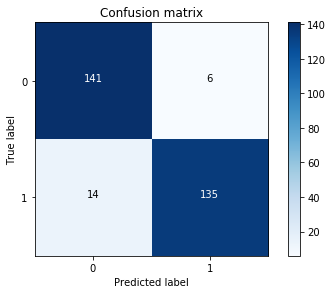

             precision    recall  f1-score   support

          0       0.91      0.96      0.93       147
          1       0.96      0.91      0.93       149

avg / total       0.93      0.93      0.93       296



In [56]:
fraud_indices = np.array(data[data.Class == 1].index)
print 'Number of frauds', len(fraud_indices)

non_fraud = data[data.Class==0]
fraud = data[data.Class==1]

print 'number of non fraud: ', len(non_fraud)
non_fraud = non_fraud.loc[np.random.choice(non_fraud.index, len(fraud_indices), replace=False)]

data = pd.concat([non_fraud, fraud])
print 'non_fraud after: ', len(non_fraud)

# Call the logistic regression model with a certain C parameter
lr = LogisticRegression(C = 10)

# Assign variables x and y corresponding to row data and it's class value
X = data.ix[:, data.columns != 'Class']
y = data.ix[:, data.columns == 'Class']

# Whole dataset, training-test data splitting
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 0)

# CROSS VALIDATION
scores = cross_val_score(lr, X, y, scoring='recall', cv=5)
print scores
print 'Recall mean = ', np.mean(scores)

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
class_names = [0,1]


plt.figure()
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')
plt.show()

from sklearn.metrics import classification_report
print classification_report(y_test, y_pred)



### Evaluation 

#### As we can see, by bringing the data to a 50:50 ratio, we bring the recall performance up to 88% average! up from 60%.
This is a significant increase.